In [ ]:
!pip install efficientnet_pytorch
!unzip data.zip

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
config = {
    'nr_epochs' : 10,
    'batch_size': 16,
    'classification_lr' : 0.00005
}

##### Loading images

In [5]:
# transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# datasets
train = datasets.ImageFolder('data/train', transform=transform)
val = datasets.ImageFolder('data/validation', transform=transform)

#loaders
train_loader = DataLoader(train, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val, batch_size=config['batch_size'], shuffle=True)


##### Visualizing a sample batch

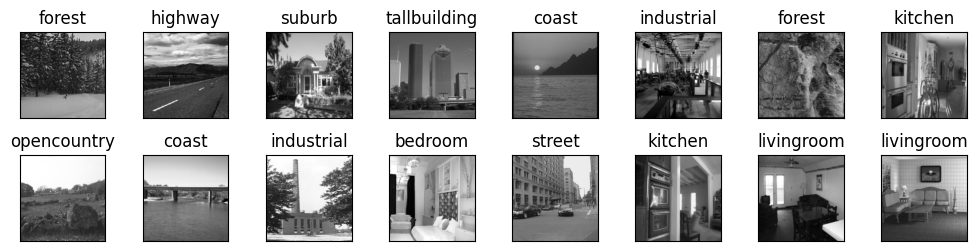

In [6]:
def visualize_batch_sample(batch_size, loader, classes):
    # batch of training images
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig = plt.figure(figsize=(10, 10))

    for idx in range(16):
        ax = fig.add_subplot(int(batch_size/2), int(batch_size/2), idx+1, xticks=[], yticks=[])
        img = images[idx].numpy().transpose((1, 2, 0))
        ax.imshow(img)
        # Label the image
        ax.set_title(classes[labels[idx]])

    plt.tight_layout()
    plt.show()

class_names = train.classes
visualize_batch_sample(config['batch_size'], train_loader, classes=class_names)

In [7]:
def make_plot(train_list, val_list, _type, nr_epochs=config['nr_epochs']):
  plt.figure()
  plt.plot(range(nr_epochs), train_list, label='Train ' + _type)
  plt.plot(range(nr_epochs), val_list, label='Val ' + _type)
  plt.xlabel('Epoch')
  plt.ylabel(_type)
  plt.legend()
  plt.show()

##### Training and evaluation functions

In [8]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects.double() / len(train_loader.dataset)

    return train_loss, train_acc

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)

    return val_loss, val_acc

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, filename, nr_epochs=config['nr_epochs']):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(nr_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())

        print(f'Epoch {epoch}/{nr_epochs - 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    torch.save(model.state_dict(), filename)
    return train_losses, val_losses, train_accs, val_accs

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def generate_confusion_matrix(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds_batch = torch.max(outputs, 1)
            preds.extend(preds_batch.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Use sklearn to generate the confusion matrix
    cm = confusion_matrix(true_labels, preds)
    return cm

In [10]:
def visualize_confusion_matrix(path, classes, loader):
    model = load_model(len(train.classes), path, classes, False, False)
    cm = generate_confusion_matrix(model, loader, DEVICE)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

In [11]:
# loads from file or creates a new EfficientNet model
def load_model(nr_classes, path=None, load_model_classes=None, freeze_params=False, change_fc=True):
    if path:
        # If path is provided, load the model from the path
        m1 = EfficientNet.from_pretrained('efficientnet-b0', num_classes=load_model_classes)
        m1.load_state_dict(torch.load(path))

        if not change_fc:
            m1.to(DEVICE)
            return m1

        # Create a new model with the desired number of output classes
        m2 = EfficientNet.from_pretrained('efficientnet-b0', num_classes=nr_classes)

        # Copy parameters from m1 to m2, excluding the final layer
        state_dict = m1.state_dict()
        del state_dict['_fc.weight']
        del state_dict['_fc.bias']
        m2.load_state_dict(state_dict, strict=False)

        # Freeze the parameters if specified
        if freeze_params:
            for param in m2.parameters():
                param.requires_grad = False
            # unfreeze fc layer
            for param in m2._fc.parameters():
                param.requires_grad = True
        m2.to(DEVICE)
        return m2
    else:
        # If no path is provided, just create and return a new model
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=nr_classes)
        model.to(DEVICE)
        return model

#### Train supervised model

In [12]:
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 142MB/s] 


Loaded pretrained weights for efficientnet-b0
Epoch 0/9, Train Loss: 2.5060, Train Acc: 0.3040, Val Loss: 2.3191, Val Acc: 0.5039
Epoch 1/9, Train Loss: 1.8886, Train Acc: 0.7173, Val Loss: 1.6730, Val Acc: 0.6884
Epoch 2/9, Train Loss: 1.2638, Train Acc: 0.8007, Val Loss: 1.0610, Val Acc: 0.7946
Epoch 3/9, Train Loss: 0.8030, Train Acc: 0.8680, Val Loss: 0.7164, Val Acc: 0.8345
Epoch 4/9, Train Loss: 0.5537, Train Acc: 0.8933, Val Loss: 0.5346, Val Acc: 0.8670
Epoch 5/9, Train Loss: 0.4338, Train Acc: 0.9047, Val Loss: 0.4375, Val Acc: 0.8851
Epoch 6/9, Train Loss: 0.3105, Train Acc: 0.9407, Val Loss: 0.3603, Val Acc: 0.8992
Epoch 7/9, Train Loss: 0.2385, Train Acc: 0.9540, Val Loss: 0.2953, Val Acc: 0.9112
Epoch 8/9, Train Loss: 0.2130, Train Acc: 0.9533, Val Loss: 0.2417, Val Acc: 0.9260
Epoch 9/9, Train Loss: 0.1639, Train Acc: 0.9673, Val Loss: 0.2209, Val Acc: 0.9310


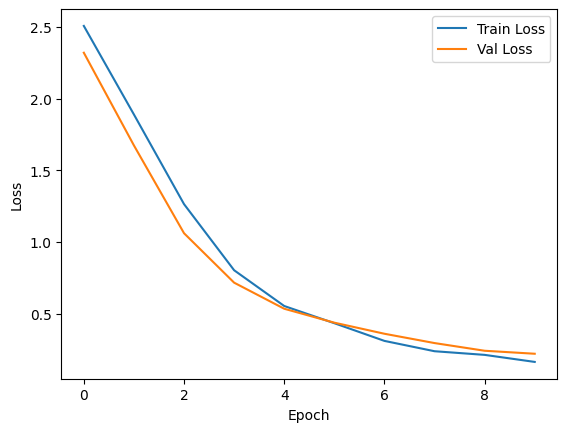

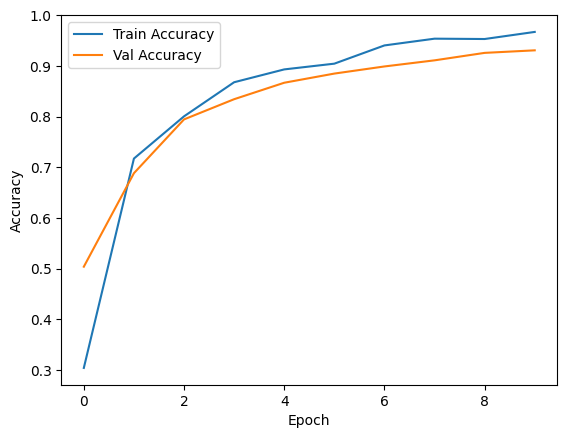

In [13]:
model = load_model(len(train.classes))
optimizer = optim.Adam(model.parameters(), lr=config['classification_lr'])

lists = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, DEVICE, "supervised.pth",config['nr_epochs'])
train_losses, val_losses, train_accs, val_accs = lists

# Plot training and validation loss & accuracy
make_plot(train_losses, val_losses, 'Loss')
make_plot(train_accs, val_accs, 'Accuracy')


Loaded pretrained weights for efficientnet-b0


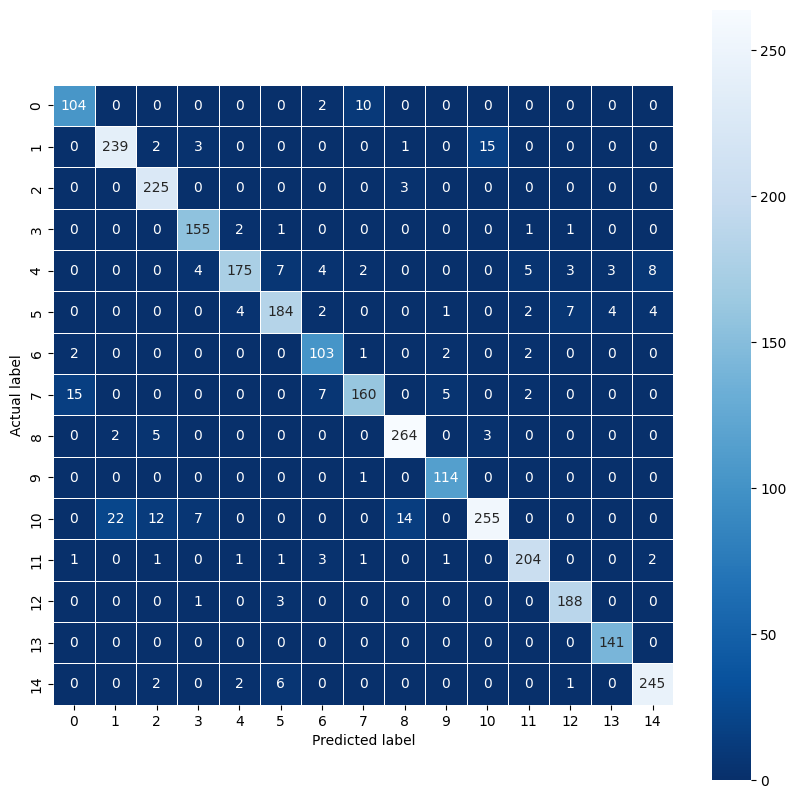

In [149]:
visualize_confusion_matrix('supervised.pth', len(train.classes), val_loader)

# Self Supervised

### Rotation Classification

In [14]:
import torchvision.transforms.functional as TF
import numpy as np

In [15]:
# rotate the data, must behave like a Dataset object in order to be able to
# use the train and evaluate functions
class RotatedDataset(Dataset):
    def __init__(self, dataset, angles=[0,90,180,270]):
        self.dataset = dataset
        self.angles = angles
        self.classes = list(range(len(self.angles)))
        self.data = []

        # Rotate images and labels
        for i in range(len(dataset)):
            image, _ = dataset[i]
            angle = np.random.choice(self.angles).item()
            rotated_image = TF.rotate(image, angle)
            new_label = self.angles.index(angle)
            self.data.append((rotated_image, new_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

#### Rotate train and val images randomly

In [16]:
rotated_train = RotatedDataset(train)
rotated_val = RotatedDataset(val)
rotated_train_loader = DataLoader(rotated_train, batch_size=config['batch_size'], shuffle=True)
rotated_val_loader = DataLoader(rotated_val, batch_size=config['batch_size'], shuffle=True)

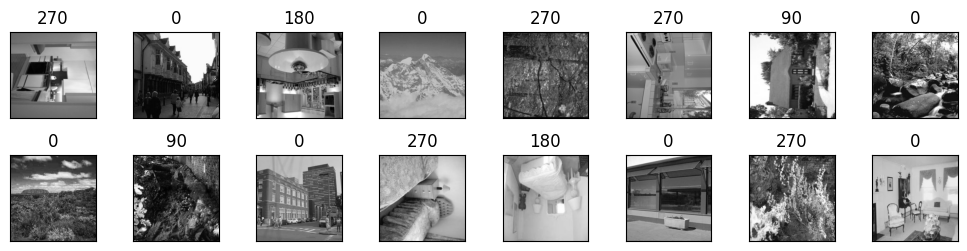

In [23]:
visualize_batch_sample(16, rotated_train_loader, [0,90,180,270])

#### Train on rotation classification task

Loaded pretrained weights for efficientnet-b0
Epoch 0/9, Train Loss: 1.3039, Train Acc: 0.4160, Val Loss: 1.2193, Val Acc: 0.5487
Epoch 1/9, Train Loss: 1.0006, Train Acc: 0.6893, Val Loss: 0.8824, Val Acc: 0.6596
Epoch 2/9, Train Loss: 0.7053, Train Acc: 0.7780, Val Loss: 0.6590, Val Acc: 0.7136
Epoch 3/9, Train Loss: 0.5343, Train Acc: 0.8340, Val Loss: 0.5646, Val Acc: 0.7809
Epoch 4/9, Train Loss: 0.3774, Train Acc: 0.8960, Val Loss: 0.4259, Val Acc: 0.8449
Epoch 5/9, Train Loss: 0.2516, Train Acc: 0.9327, Val Loss: 0.3314, Val Acc: 0.8841
Epoch 6/9, Train Loss: 0.1868, Train Acc: 0.9547, Val Loss: 0.2861, Val Acc: 0.8985
Epoch 7/9, Train Loss: 0.1363, Train Acc: 0.9620, Val Loss: 0.2653, Val Acc: 0.8992
Epoch 8/9, Train Loss: 0.1073, Train Acc: 0.9713, Val Loss: 0.2638, Val Acc: 0.9015
Epoch 9/9, Train Loss: 0.0846, Train Acc: 0.9747, Val Loss: 0.2613, Val Acc: 0.9045


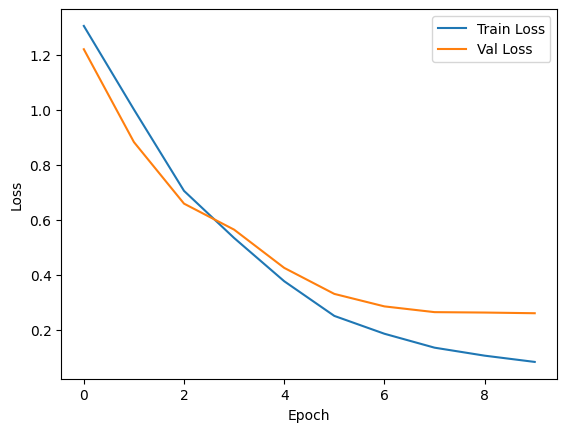

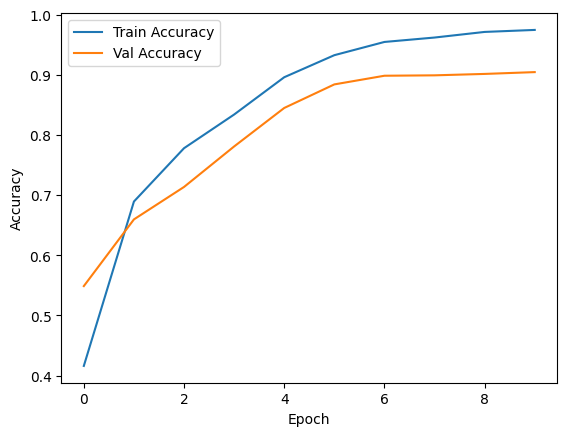

In [24]:
model = load_model(len(rotated_train_loader.dataset.classes))
optimizer = optim.Adam(model.parameters(), 0.00005)

train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, rotated_train_loader, rotated_val_loader, criterion, optimizer, DEVICE, 'rotation_pre.pth'
)
make_plot(train_losses, val_losses, 'Loss')
make_plot(train_accs, val_accs, 'Accuracy')


Loaded pretrained weights for efficientnet-b0


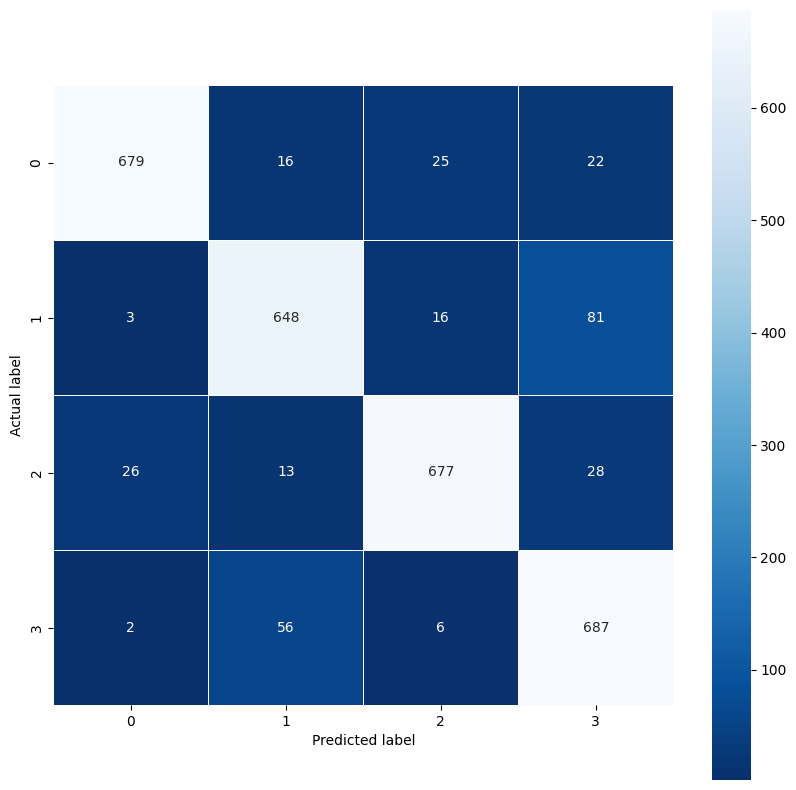

In [154]:
visualize_confusion_matrix(
    'rotation_pre.pth',
    len(rotated_train_loader.dataset.classes),
    rotated_val_loader
    )

#### Training for the main task

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Epoch 0/29, Train Loss: 2.5992, Train Acc: 0.1747, Val Loss: 2.4331, Val Acc: 0.2482
Epoch 1/29, Train Loss: 2.3351, Train Acc: 0.3760, Val Loss: 2.1803, Val Acc: 0.4402
Epoch 2/29, Train Loss: 2.1175, Train Acc: 0.5053, Val Loss: 1.9801, Val Acc: 0.5420
Epoch 3/29, Train Loss: 1.9455, Train Acc: 0.5800, Val Loss: 1.8214, Val Acc: 0.6017
Epoch 4/29, Train Loss: 1.8341, Train Acc: 0.5933, Val Loss: 1.6938, Val Acc: 0.6281
Epoch 5/29, Train Loss: 1.7011, Train Acc: 0.6480, Val Loss: 1.5840, Val Acc: 0.6603
Epoch 6/29, Train Loss: 1.6033, Train Acc: 0.6707, Val Loss: 1.4855, Val Acc: 0.6797
Epoch 7/29, Train Loss: 1.5478, Train Acc: 0.6747, Val Loss: 1.4047, Val Acc: 0.6982
Epoch 8/29, Train Loss: 1.4359, Train Acc: 0.7033, Val Loss: 1.3315, Val Acc: 0.7122
Epoch 9/29, Train Loss: 1.3659, Train Acc: 0.7320, Val Loss: 1.2669, Val Acc: 0.7223
Epoch 10/29, Train Loss: 1.3139, Train Acc: 0.7327, Val Lo

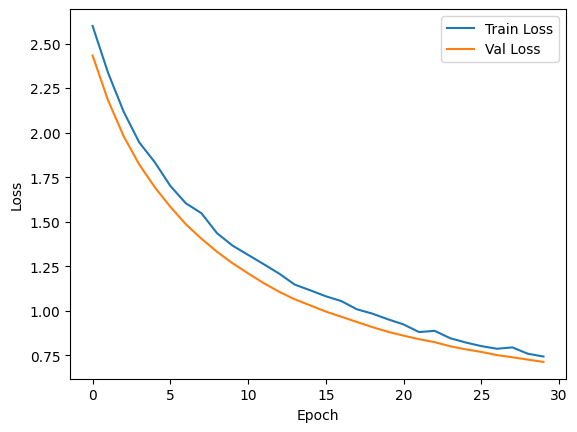

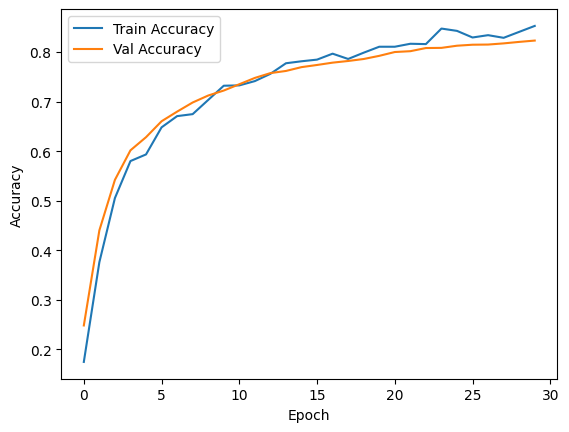

In [17]:
model = load_model(
    nr_classes=len(train.classes),
    path='rotation_pre.pth',
    load_model_classes=len(rotated_train_loader.dataset.classes),
    freeze_params=True
)
epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer, DEVICE, 'rotation-main.pth', epochs
)
make_plot(train_losses, val_losses, 'Loss', epochs)
make_plot(train_accs, val_accs, 'Accuracy', epochs)


Loaded pretrained weights for efficientnet-b0


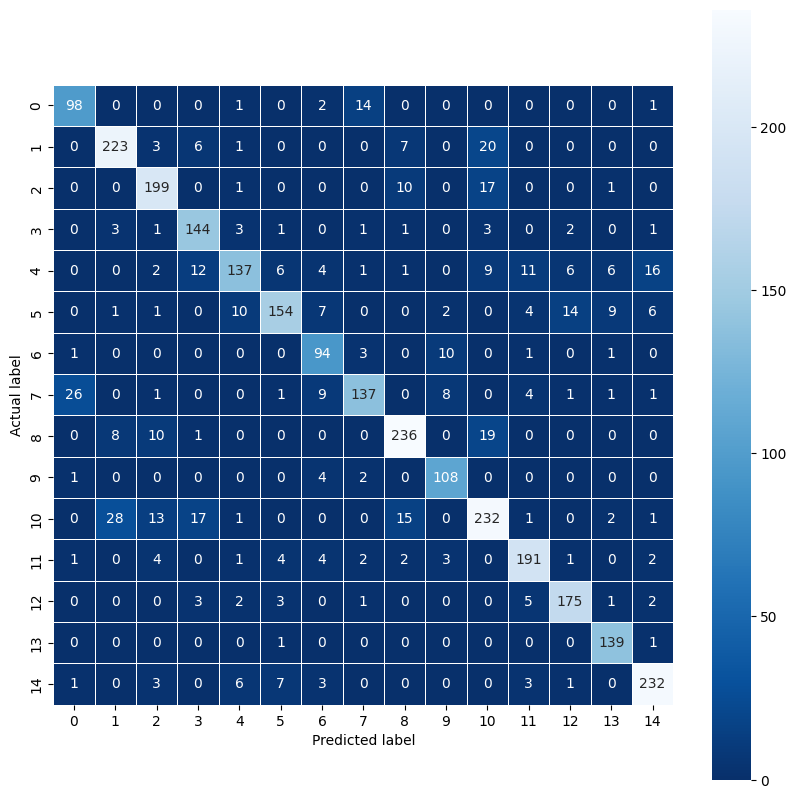

In [35]:
visualize_confusion_matrix(
    'rotation-main.pth',
    len(train.classes),
    val_loader
    )

###Black and White Perturbation

In [18]:
class PerturbedDataset(Dataset):
    def __init__(self, dataset, perturbations=[0, 255]):
        self.dataset = dataset
        self.perturbations = perturbations
        self.classes = list(range(len(self.perturbations)))
        self.data = []

        # Add perturbations to images and create labels
        for i in range(len(dataset)):
            image, _ = dataset[i]
            perturbation_value = np.random.choice(self.perturbations)
            perturbation_area = self.get_random_area(image)
            image[perturbation_area] = perturbation_value
            new_label = self.perturbations.index(perturbation_value)
            self.data.append((image, new_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @staticmethod
    def get_random_area(image):
        h, w = image.shape[1:]
        top = np.random.randint(0, h - 10)
        left = np.random.randint(0, w - 10)
        return [slice(None), slice(top, top + 10), slice(left, left + 10)]  # [C, H, W]


In [19]:
perturbed_train = PerturbedDataset(train)
perturbed_val = PerturbedDataset(val)
perturbed_train_loader = DataLoader(perturbed_train, batch_size=config['batch_size'], shuffle=True)
perturbed_val_loader = DataLoader(perturbed_val, batch_size=config['batch_size'], shuffle=True)

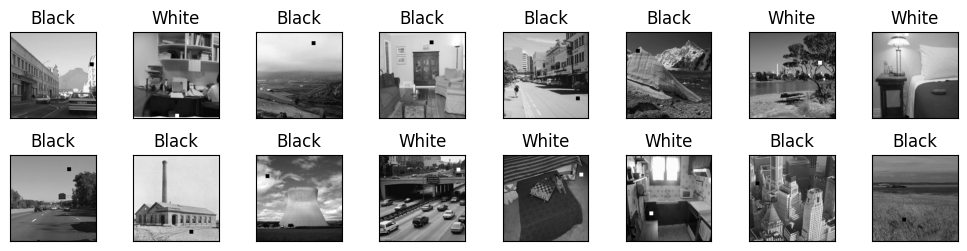

In [26]:
visualize_batch_sample(16, perturbed_train_loader, ['Black', 'White'])

Loaded pretrained weights for efficientnet-b0
Epoch 0/2, Train Loss: 0.4151, Train Acc: 0.8787, Val Loss: 0.2588, Val Acc: 0.9983
Epoch 1/2, Train Loss: 0.0615, Train Acc: 0.9967, Val Loss: 0.0805, Val Acc: 1.0000
Epoch 2/2, Train Loss: 0.0265, Train Acc: 0.9960, Val Loss: 0.0265, Val Acc: 1.0000


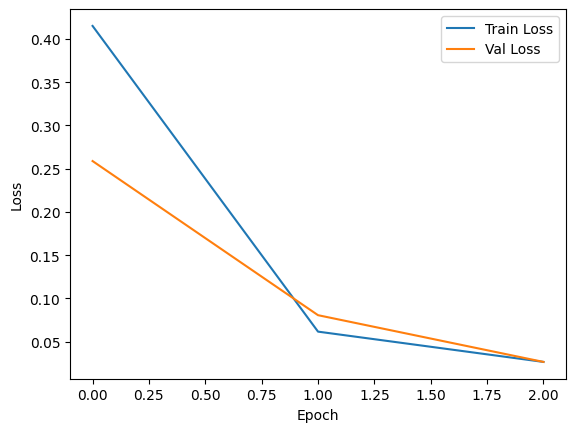

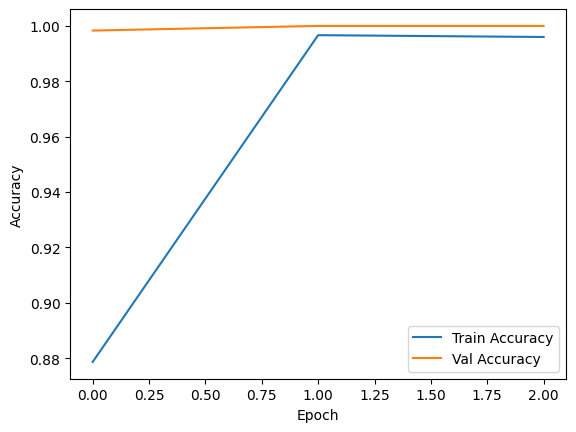

In [20]:
model = load_model(len(perturbed_train_loader.dataset.classes))
optimizer = optim.Adam(model.parameters(), 0.00005)

epochs = 3
train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, perturbed_train_loader, perturbed_val_loader, criterion, optimizer, DEVICE, 'perturbation_pre.pth',epochs
)
make_plot(train_losses, val_losses, 'Loss', epochs)
make_plot(train_accs, val_accs, 'Accuracy', epochs)

Loaded pretrained weights for efficientnet-b0


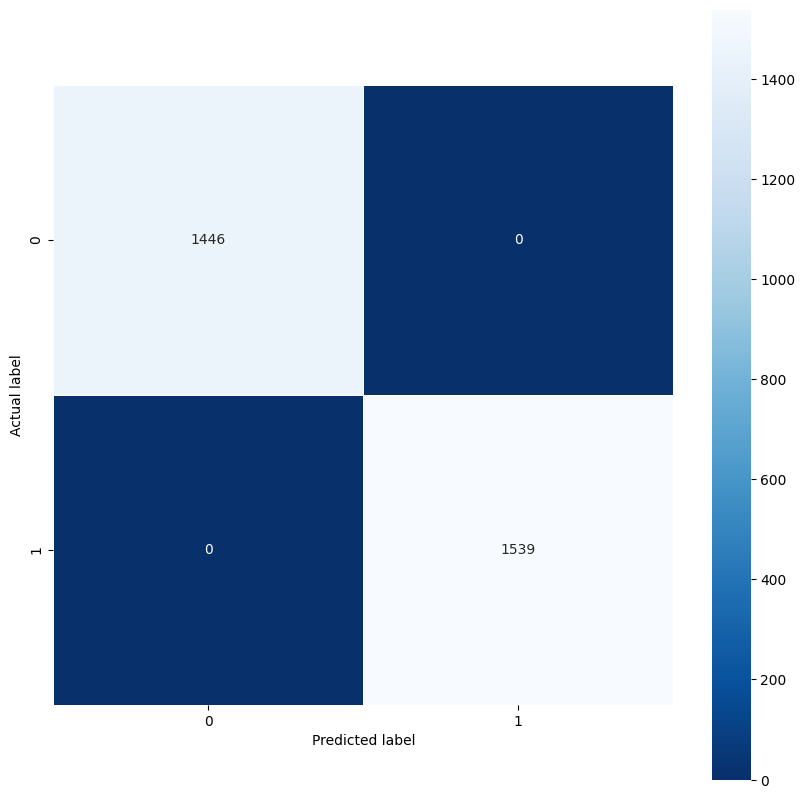

In [40]:
visualize_confusion_matrix(
    'perturbation_pre.pth',
    len(perturbed_train_loader.dataset.classes),
    perturbed_val_loader
    )

#### Classification

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Epoch 0/19, Train Loss: 2.5976, Train Acc: 0.1833, Val Loss: 2.7005, Val Acc: 0.0774
Epoch 1/19, Train Loss: 2.3272, Train Acc: 0.4353, Val Loss: 2.6594, Val Acc: 0.1394
Epoch 2/19, Train Loss: 2.1153, Train Acc: 0.5727, Val Loss: 2.5576, Val Acc: 0.2509
Epoch 3/19, Train Loss: 1.9446, Train Acc: 0.6533, Val Loss: 2.4262, Val Acc: 0.3665
Epoch 4/19, Train Loss: 1.8129, Train Acc: 0.6793, Val Loss: 2.2239, Val Acc: 0.4583
Epoch 5/19, Train Loss: 1.6809, Train Acc: 0.7100, Val Loss: 1.9517, Val Acc: 0.5926
Epoch 6/19, Train Loss: 1.5710, Train Acc: 0.7367, Val Loss: 1.6650, Val Acc: 0.6911
Epoch 7/19, Train Loss: 1.4745, Train Acc: 0.7453, Val Loss: 1.4873, Val Acc: 0.7296
Epoch 8/19, Train Loss: 1.3824, Train Acc: 0.7553, Val Loss: 1.3766, Val Acc: 0.7534
Epoch 9/19, Train Loss: 1.2950, Train Acc: 0.7727, Val Loss: 1.2983, Val Acc: 0.7668
Epoch 10/19, Train Loss: 1.2315, Train Acc: 0.7880, Val Lo

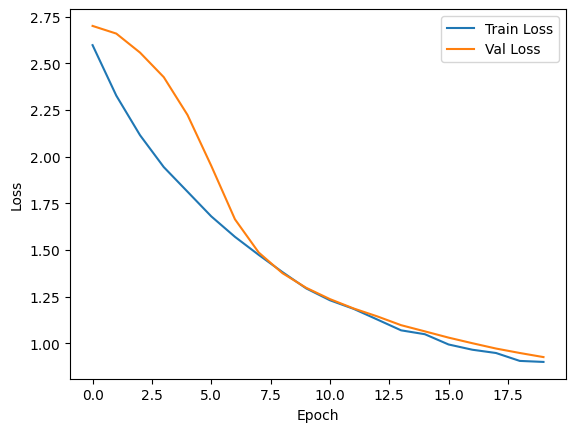

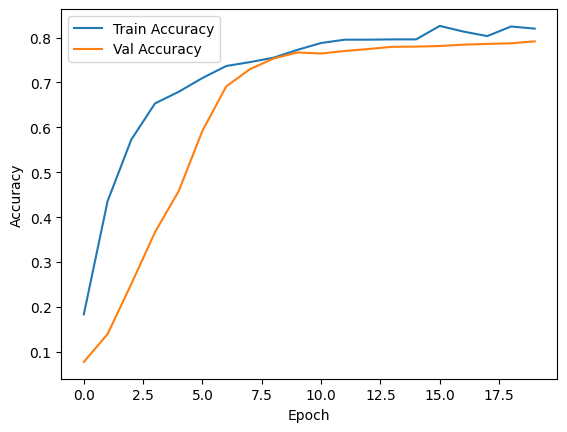

In [21]:
model = load_model(
    nr_classes=len(train.classes),
    path='perturbation_pre.pth',
    load_model_classes=len(perturbed_train_loader.dataset.classes),
    freeze_params=True
)
epochs = 20
optimizer = optim.Adam(model.parameters(), 0.00015)
train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer, DEVICE, 'perturbation-main.pth', epochs
)
make_plot(train_losses, val_losses, 'Loss', epochs)
make_plot(train_accs, val_accs, 'Accuracy', epochs)

Loaded pretrained weights for efficientnet-b0


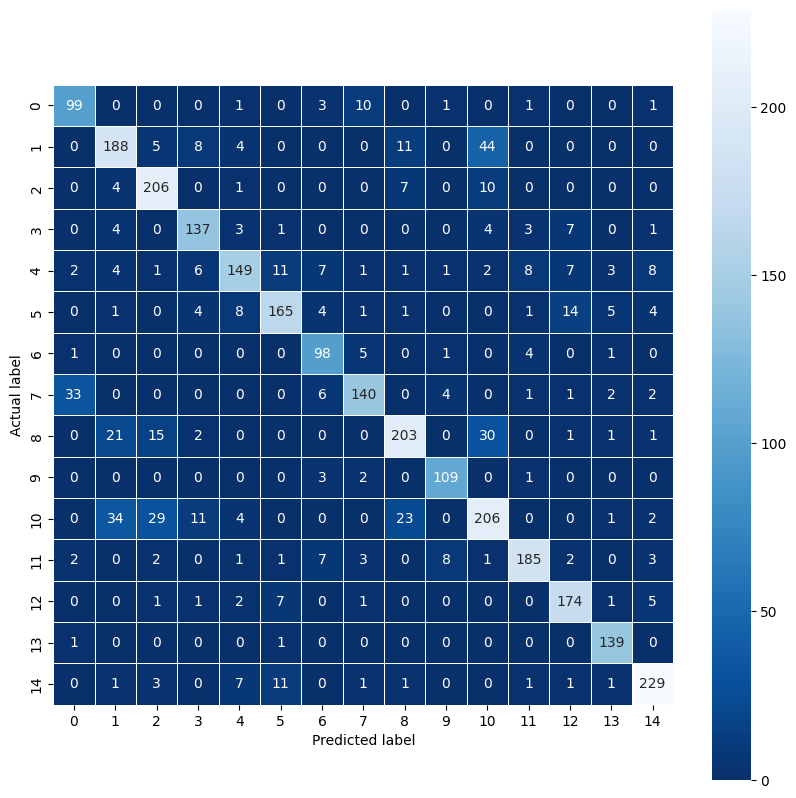

In [96]:
visualize_confusion_matrix(
    'perturbation-main.pth',
    len(train.classes),
    val_loader
    )

In [24]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize

In [28]:
examples = [
    'data/validation/tallbuilding/image_0008.jpg',
    'data/validation/suburb/image_0036.jpg',
    'data/validation/coast/image_0024.jpg',
    'data/validation/office/image_0010.jpg',
    'data/validation/insidecity/image_0011.jpg',
    'data/validation/highway/image_0070.jpg',
    'data/validation/mountain/image_0007.jpg',
    'data/validation/street/image_0055.jpg'
]


In [30]:
import os
def visualize_cam_on_images(images, models_paths):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    models = [
        (
            os.path.splitext(os.path.basename(model_path))[0],
            load_model(
                nr_classes=len(val.classes),
                path=model_path,
                load_model_classes=len(val.classes),
                freeze_params=False,
                change_fc=False
                )) for model_path in models_paths
        ]

    for image_path in images:
        image = Image.open(image_path).convert('RGB')
        tensor = preprocess(image)
        tensor = tensor.unsqueeze(0)
        tensor = tensor.to(DEVICE)

        plt.figure(figsize=(15, 15))

        # Display original image in first cell
        plt.subplot(4, 4, 1)
        plt.title('Original')
        plt.imshow(image)
        plt.axis('off')

        for j, (model_name, model) in enumerate(models):
            model.eval()

            # the target layers you want to visualize
            target_layers = [model._blocks[0]._project_conv, model._blocks[15]._project_conv]

            for i, target_layer in enumerate(target_layers):
                wrapped_model = ScoreCAM(model, target_layer)
                cam, idx = wrapped_model(tensor)
                plt.subplot(4, 4, 4*i+j+2)
                plt.title(f'{model_name}, Target {i+1}')
                plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
                plt.axis('off')

        plt.show()


In [26]:
models_paths = ['supervised.pth', 'rotation-main.pth', 'perturbation-main.pth']

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


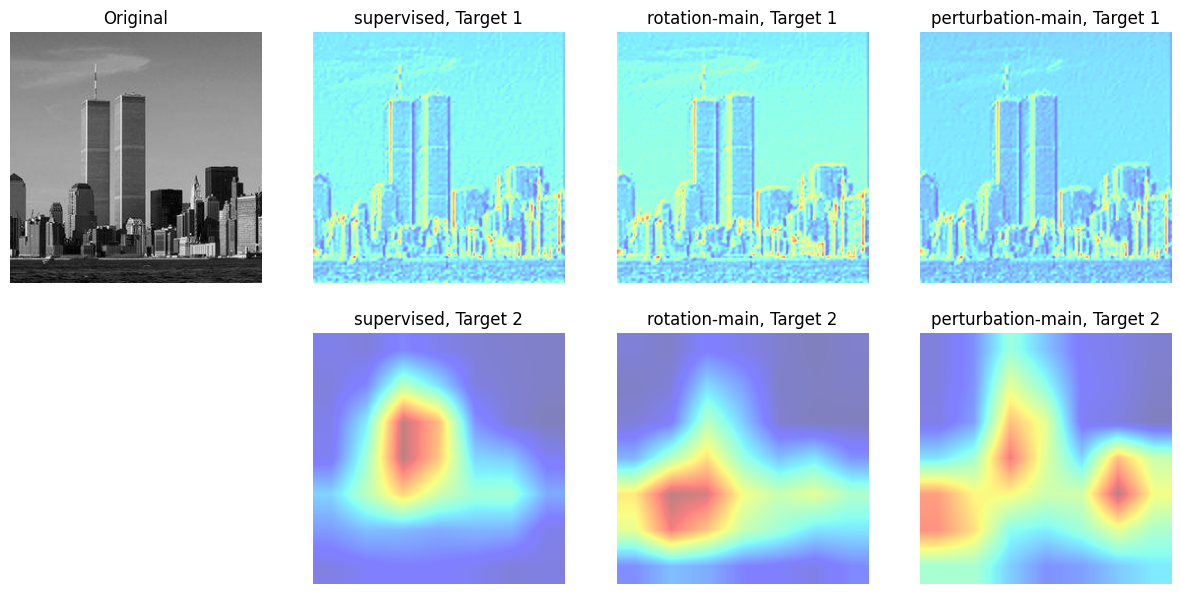

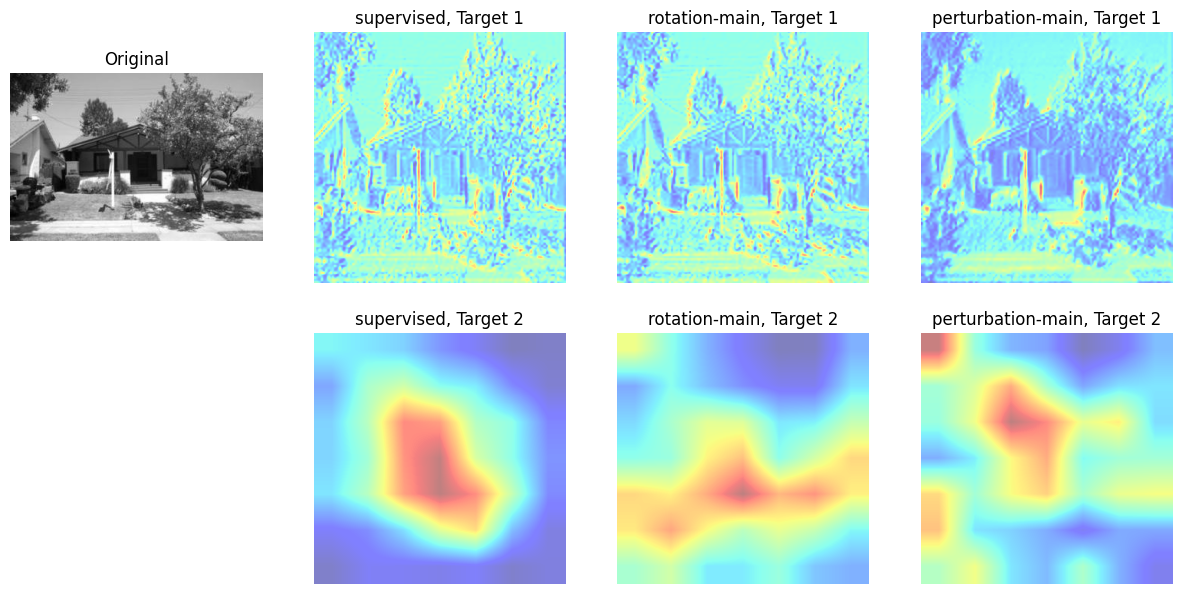

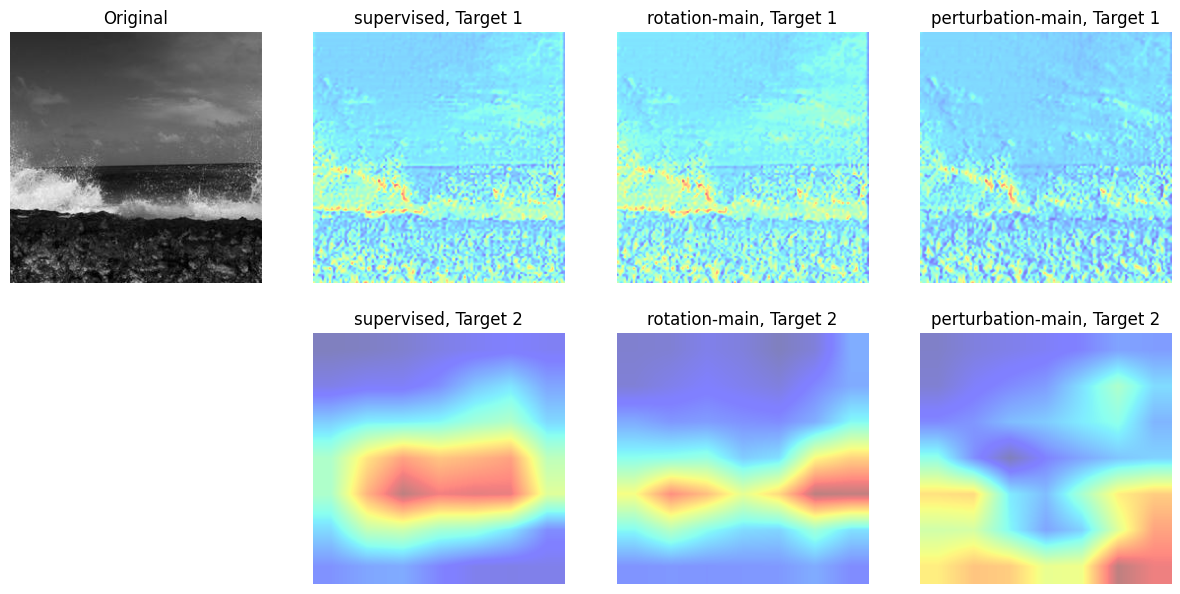

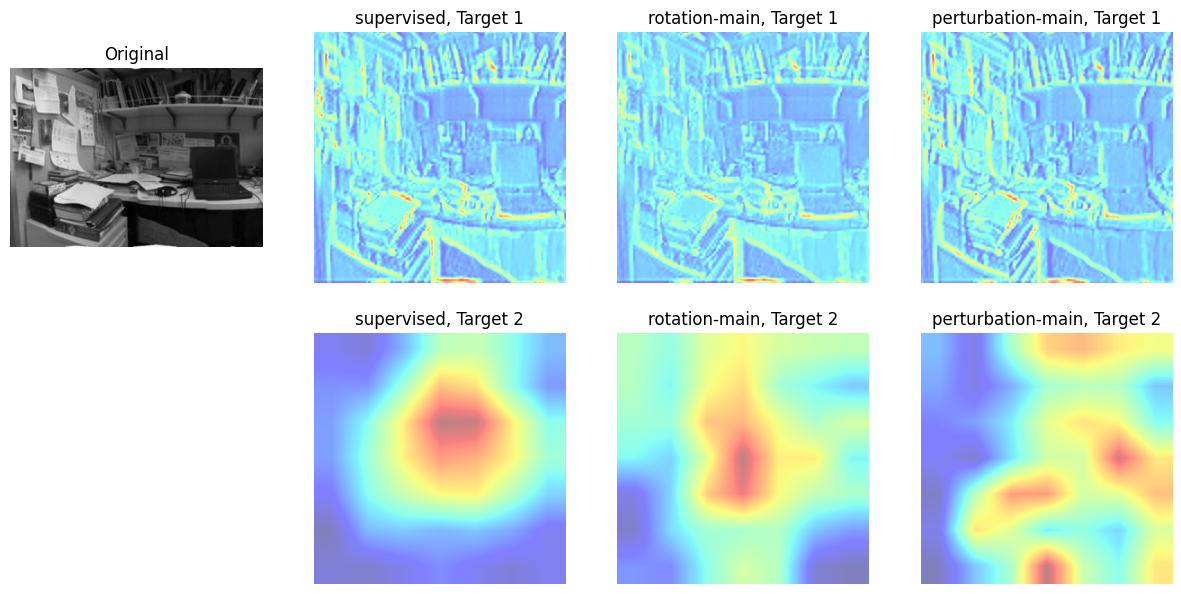

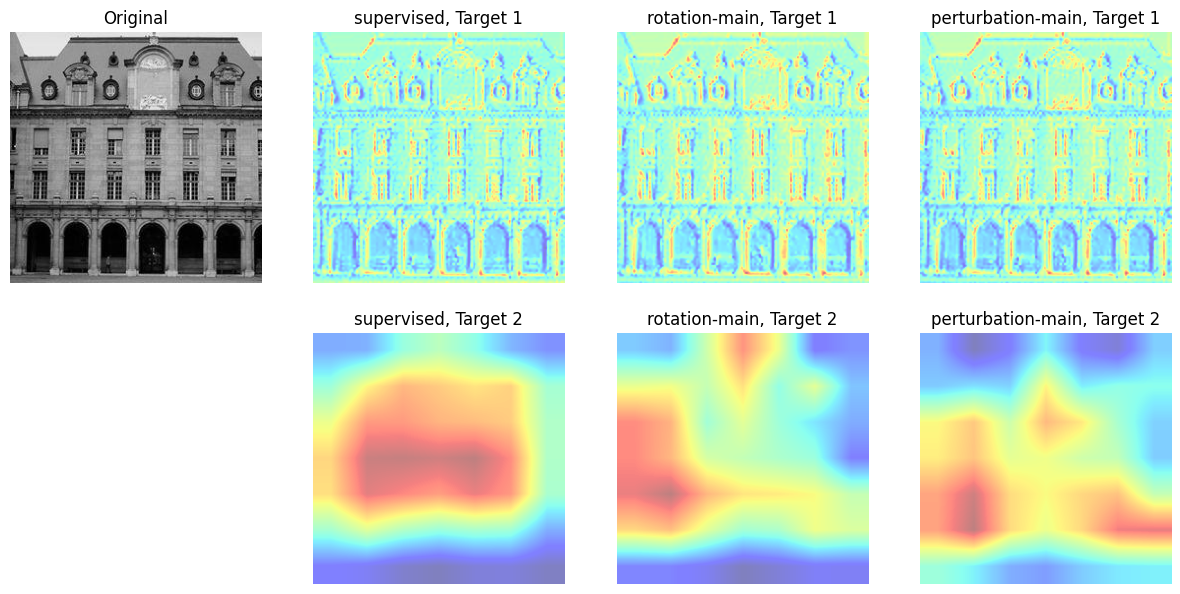

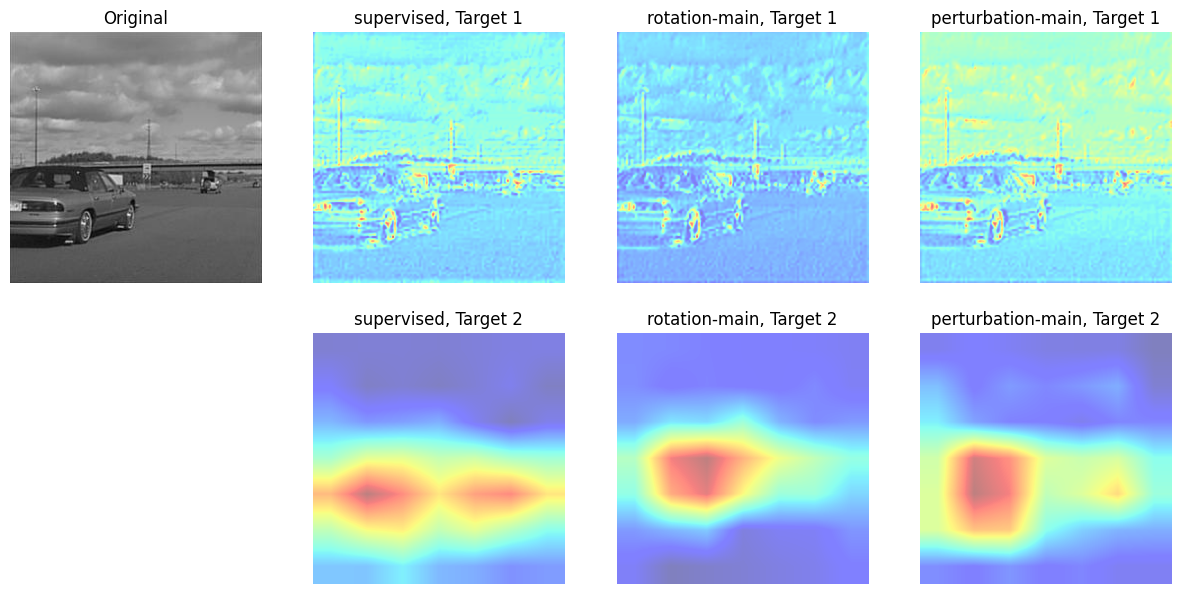

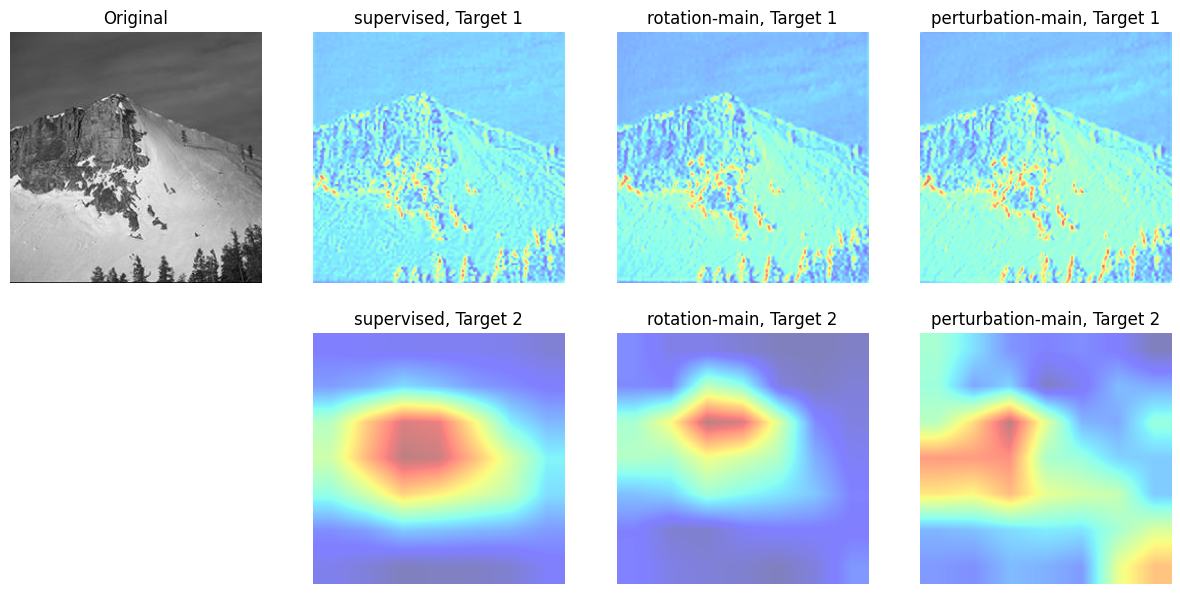

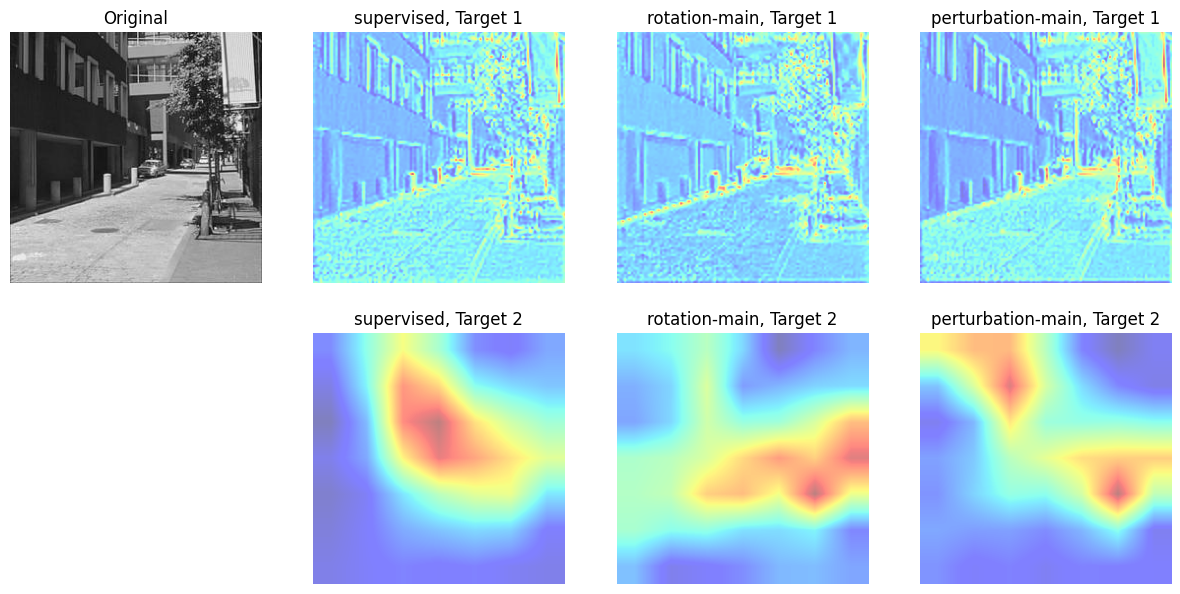

In [31]:
visualize_cam_on_images(examples, models_paths)

In [33]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration

In [37]:
target_class = 6
pretrained_model = load_model(
    nr_classes=len(val.classes),
    path='perturbation-main.pth',
    load_model_classes=len(val.classes),
    freeze_params=False,
    change_fc=False
)
csig = RegularizedClassSpecificImageGeneration(pretrained_model, target_class)
csig.generate()

Loaded pretrained weights for efficientnet-b0
Iteration: 16 Loss 24990.40
Iteration: 33 Loss 45172.98
Iteration: 50 Loss 20291.81
Iteration: 66 Loss 139093.64
Iteration: 83 Loss 126965.44
Iteration: 100 Loss 221695.39
Iteration: 116 Loss 99311.73
Iteration: 133 Loss 44675.11


tensor([[[[  2.3847,   2.1952,   0.9508,  ...,   2.8779,  -0.1792,  -2.4380],
          [  2.0340,   1.9273,   0.3660,  ...,   3.4944,  -1.7712,  -2.6187],
          [  1.2924,   1.6469,   1.6692,  ...,   2.0050,  -1.1635,  -3.7120],
          ...,
          [ -2.1679,  -2.0514,  -2.0813,  ..., -20.7202,   8.8539,  18.4896],
          [ -2.0196,  -1.9157,  -1.9153,  ...,   3.6729,  13.2937,   5.7877],
          [ -1.8998,  -1.8782,  -2.5550,  ...,  13.9435,   2.4515,  -3.3812]],

         [[  0.1386,   0.7167,   1.4016,  ...,  -2.9508,  -1.1785,   2.8009],
          [  1.6066,   1.8192,   2.5427,  ...,  -2.7867,   1.4283,   3.0472],
          [  2.1763,   1.8599,   0.1524,  ...,  -1.6818,  -0.2413,   4.2409],
          ...,
          [  2.8370,   3.0567,   2.0255,  ...,  28.5822,  -3.3279, -11.9805],
          [  2.7104,   2.7497,   2.9179,  ...,  -5.4221, -10.4065,  -1.9549],
          [  2.5382,   2.5403,   4.1406,  ..., -26.0225,   2.2038,   6.8197]],

         [[ -1.9339,  -2.0194,